# Test out the basic conditional VAE
* Also look at how it generates per class, and from sampling

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))
from models.cifar import ResNet

from utils.loading import load_net
from utils.data import make_generators_DF_cifar
from utils.train_val import validate_epoch
from utils.evaluation import evaluate_adv_files_df, get_metrics

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms

import foolbox
import json
from PIL import Image

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
print(torch.cuda.current_device())

cuda:1
2
0


In [2]:
def display_results_auto(vae_model, files_df, num_samples=5, label_col_name='class'):
    size = 32
    with torch.cuda.device(1): # ??? Why the fuck???
        all_labels = files_df[label_col_name].unique()
        num_labels = len(all_labels)
        row_names = []
        col_names = ['Original', "Reconstructed"]

        fig, ax = plt.subplots(num_samples, 2, sharex='col', sharey='row',figsize=(15,15))

        for i, label in enumerate(all_labels[0:num_samples]):
            sample_df = files_df.loc[files_df[label_col_name] == label].sample(n=1)
            img_path = sample_df['path'].iloc[0]
            label = sample_df[label_col_name].iloc[0]
            row_names.append(label)

            if model.layer_sizes[0] == 1: # MNIST
                img = read_img_to_np(img_path, bw=True)
                transform = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.1307,), (0.3081,))])
            else: # CIFAR10
                img = read_img_to_np(img_path, bw=False)
                transform = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.4914, 0.4822, 0.4465], 
                                                                     [0.2023, 0.1994, 0.2010])])

            tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

            tensor_label = torch.from_numpy(np.array(label)).unsqueeze(0).type(torch.LongTensor).to(device)
            recon_x, mu, logvar = model(tensor_img, tensor_label)            

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(torch_to_np(recon_x))
            ax[i, 0].axis('off')
            ax[i, 1].axis('off')

        for curr_ax, col in zip(ax[0], col_names):
            curr_ax.set_title(col)

        for curr_ax, row in zip(ax[:,0], row_names):
            curr_ax.set_ylabel(row, rotation=0, size='large')
            

In [3]:
model_loc = '/media/rene/data/adv_consistency/MNIST/mnist_normal/models/CVAE-1_16_32_64-16-MNIST-10_model_best.pth.tar'
model = load_net(model_loc).to(device).eval()

files_df_loc = '/media/rene/data/adv_consistency/MNIST/mnist_normal/files_df.pkl'

with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

decoder fc input size torch.Size([1, 16])
decoder input size torch.Size([1, 64, 4, 4])
decoder fc input size torch.Size([1, 16])
decoder input size torch.Size([1, 64, 4, 4])
decoder fc input size torch.Size([1, 16])
decoder input size torch.Size([1, 64, 4, 4])


/media/rene/ADV/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:177: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.")
/media/rene/ADV/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


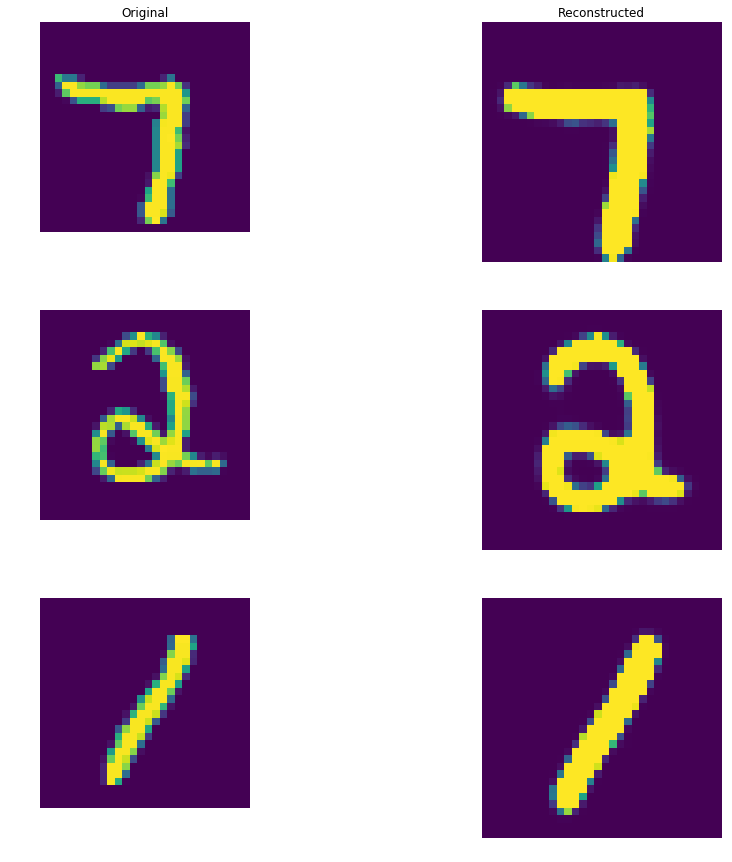

In [4]:
display_results_auto(model, files_df['val'], num_samples=3)

## Try CIFAR10
* This needs work

In [18]:
model_loc = '/media/rene/data/adv_consistency/cifar10/cifar10_normal/models/CVAE-3_32_64_128-32-CIFAR10-10_model_best.pth.tar'
files_df_loc = '/media/rene/data/adv_consistency/cifar10/cifar10_normal/files_df.pkl'
model = load_net(model_loc).to(device).eval()

with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

/media/rene/ADV/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:177: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.")
/media/rene/ADV/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


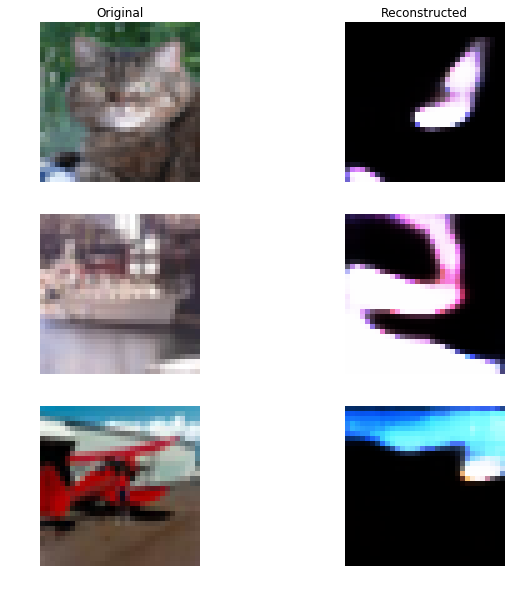

In [19]:
display_results_auto(model, files_df['val'], num_samples=3)

/media/rene/ADV/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:177: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.")
/media/rene/ADV/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


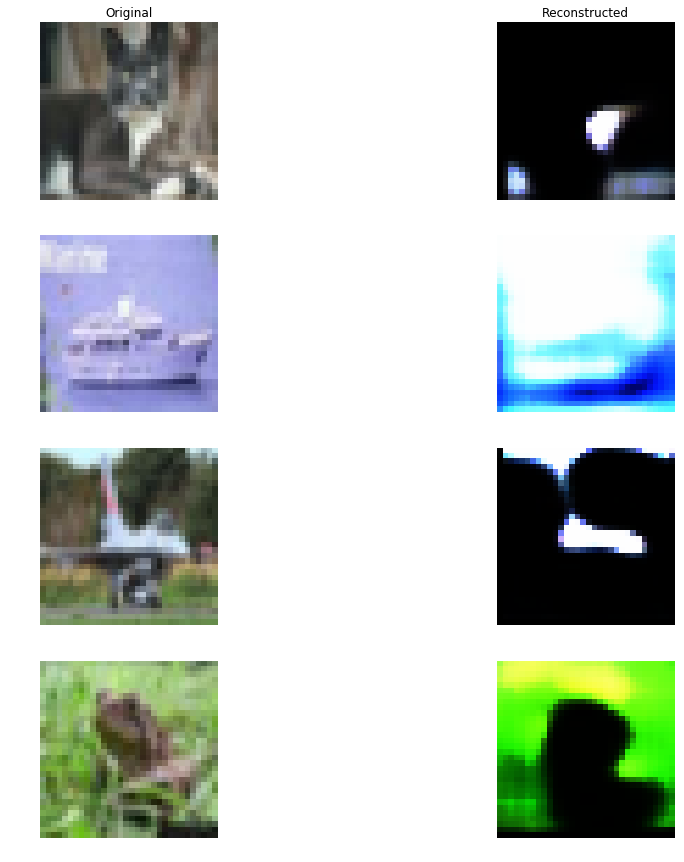

In [11]:
model_loc = '/media/rene/data/adv_consistency/cifar10/cifar10_normal/models/CVAE-3_32_64_128-32-CIFAR10-10_model_best.pth.tar'
files_df_loc = '/media/rene/data/adv_consistency/cifar10/cifar10_normal/files_df.pkl'
model = load_net(model_loc).to(device).eval()

with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)
    
display_results_auto(model, files_df['val'], num_samples=4)